In [1]:
import pandas as pd
import glob
import os
import librosa
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Loading data

## Annotations

In [14]:
elan_annotation_paths = ['../annotations/surf.txt']
praat_annotation_paths = ['../annotations/lavina_class.TextGrid',
                          '../annotations/dtp.TextGrid',
                          '../annotations/artem_vps.TextGrid',
                          '../annotations/dima_arxiv.TextGrid',
                          '../annotations/sasha_code.TextGrid' ]

In [15]:
def get_elan_annotations(paths):
    dfs = []
    for path in paths:
        df = pd.read_csv(path, sep='\t', header=None)
        df = df[[3, 5, 7, 8]]
        df = df.rename(columns={3: 'start', 5: 'finish', 7: 'length', 8: 'label'})
        dfs.append(df)
    return dfs

In [16]:
elan_annotations = get_elan_annotations(elan_annotation_paths)

In [17]:
elan_annotations[0].head()

,start,finish,length,label
0,0.018,144.237,144.219,c
1,146.801,147.044,0.243,a
2,150.407,150.600,0.193,b
3,152.654,152.968,0.314,a
4,154.260,154.705,0.445,a


In [18]:
def get_praat_annotations(paths):
    dfs = []
    for path in paths:
        with open(path) as f:
            annotation = [l.strip() for l in f.readlines()]
            
        indxs = [i for i, l in enumerate(annotation) if l == '"IntervalTier"']
        annotation = annotation[indxs[0] + 5:indxs[1] if len(indxs) > 1\
                                else len(annotation)]
        annotation_dicts = []

        for s, e, l in zip(annotation[0::3], annotation[1::3], annotation[2::3]):
            annotation_dicts.append({
                'start': float(s),
                'finish': float(e),
                'label': l.replace('"', ''),
                'length': float(e) - float(s)
            })
        df = pd.DataFrame(annotation_dicts)
        dfs.append(df)
    return dfs

In [19]:
praat_annotations = get_praat_annotations(praat_annotation_paths)

In [20]:
praat_annotations[0].head()

,finish,label,length,start
0,1.549987,c,1.549987,0.000000
1,1.905032,a,0.355045,1.549987
2,12.203617,c,10.298584,1.905032
3,12.685464,a,0.481847,12.203617
4,16.796116,c,4.110652,12.685464


In [21]:
praat_annotations[1].head()

,finish,label,length,start
0,37.323779,,37.323779,0.000000
1,37.647123,a,0.323345,37.323779
2,130.266718,,92.619594,37.647123
3,130.571042,b,0.304325,130.266718
4,130.792946,,0.221903,130.571042


In [22]:
annotations = elan_annotations.copy()
annotations.extend(praat_annotations)

## Audio

In [23]:
audio_paths = [
    '../audio/surf.m4a',
    '../audio/lavina_class.m4a',
    '../audio/dtp.m4a',
    '../audio/artem_vps.m4a',
    '../audio/dima_arxiv.m4a',
    '../audio/sasha_code.m4a'
]

In [24]:
def get_audios(paths):    
    res = []
    for path in paths:
        audio, sr = librosa.load(path)
        res.append(audio)
    return res, sr

def get_label_data(annotation, audio, label, sr):
    start_samples_indxs = librosa.time_to_samples(annotation[annotation.label ==\
                                                              label].start.values, sr)
    finish_samples_indxs = librosa.time_to_samples(annotation[annotation.label ==\
                                                               label].finish.values, sr)
    
    data = []
    for s, f in zip(start_samples_indxs, finish_samples_indxs):
        data.append(audio[np.arange(s, f)])
    return data

def get_unlabel_data(annotation, audio, labels, sr):
    start_samples_indxs = librosa.time_to_samples(\
                          annotation[annotation.label.isin(labels)].start.values, sr)
    finish_samples_indxs = librosa.time_to_samples(\
                           annotation[annotation.label.isin(labels)].finish.values, sr)
    finish_samples_indxs = np.hstack([[0], finish_samples_indxs])
    start_samples_indxs = np.hstack([start_samples_indxs, [len(start_samples_indxs) - 1]])
    
    data = []
    for s, f in zip(finish_samples_indxs, start_samples_indxs):
        data.append(audio[np.arange(s, f)])
    return data

In [25]:
audios, sr = get_audios(audio_paths)

## Demo examples of classes

In [41]:
data_a = get_label_data(annotations[0], audios[0], 'a', sr)
merged_data_a = np.hstack(data_a)
librosa.output.write_wav('../demo/label_a_tmp.wav', merged_data_a, sr)

In [42]:
data_a = get_label_data(annotations[0], audios[0], 'b', sr)
merged_data_a = np.hstack(data_a)
librosa.output.write_wav('../demo/label_b_tmp.wav', merged_data_a, sr)

In [57]:
data_a = get_unlabel_data(annotations[2], audios[2], ['a', 'b'], sr)
merged_data_a = np.hstack(data_a)
librosa.output.write_wav('../demo/label_c_tmp.wav', merged_data_a, sr)

## Creating dataset

In [26]:
interval_time = 0.1
interval_len = librosa.time_to_samples(interval_time)[0]

step_time = 0.05
step_len = librosa.time_to_samples(step_time)[0]

In [27]:
interval_len, step_len

(2205, 1102)

In [28]:
def get_label_data(annotation, audio, labels, sr=22050):
    # по дефолту все 2го класса
    data = pd.Series(index=np.arange(0, len(audio) - interval_len, step_len), data=2)
    label_map = {'a': 0, 'b': 1, 'c': 2}
    for label in labels:
        l = label_map[label]
        start_samples_indxs = librosa.time_to_samples(annotation[annotation.label ==\
                                                              label].start.values, sr)
        finish_samples_indxs = librosa.time_to_samples(annotation[annotation.label ==\
                                                               label].finish.values, sr)
        for s, f in zip(start_samples_indxs, finish_samples_indxs):
            s = int(np.round(s / step_len)) * step_len
            f = (int(np.round(f / step_len)) - 2) * step_len
            # вычитаем 2 потому что f - это конец интервала, в Series мы заносим метку для 
            # начала  интервала(с которого мы возьмем кусок длинной в interval_len)
            # длина интервала 2 * step, поэтому нужно вычесть 2
            data[(data.index >= s) & (data.index <= f)] = l
    return data

### Так нельзя, так как тогда в выборку просто не попадут данные с нуу ни в один класс

In [29]:
# d = get_label_data(annotations[0], audios[0], ['a', 'b']) # с классом "нуу"
# d = get_label_data(annotations[0], audios[0], ['a']) # без "нуу" 

### Надо так

In [30]:
d = get_label_data(annotations[0], audios[0], ['a', 'b'])

In [31]:
d.value_counts()

2    24782
0      711
1      150
dtype: int64

In [32]:
d = d.replace({1:2})

In [33]:
d.value_counts()

2    24932
0      711
dtype: int64

In [34]:
d.value_counts(True)

2    0.972273
0    0.027727
dtype: float64

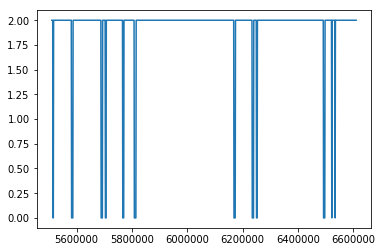

In [35]:
d.iloc[5000:6000].plot()

In [43]:
X, y = [], []

labels_map = {
    'a': 0,
    'b': 1,
    'c': 2
}

for ann, aud in zip(annotations, audios):
    data = get_label_data(ann, aud, ['a', 'b'])
    data = data.replace({1:2}) # убираем класс ну, можно закоментить
    vc = data.value_counts()
#     print(data.value_counts(True))
    c_to_sample = 9 * vc[0] # делаем "не эээ" в 10 раз больше чем "ээ" 
                             # (на самом деле его больше в ~20раз)
    
    d = data[data == 0]
    for i in d.index:
#         print(i, interval_len, aud.shape, len(X))
        X.append(aud[i: i + interval_len])
        y += [0]
        
    d = data[data == 1]
    for i in d.index:
        X.append(aud[i: i + interval_len])
        y += [1]
        
    d = data[data == 2].sample(c_to_sample)
    for i in d.index:
        X.append(aud[i: i + interval_len])
        y += [2]

In [44]:
pd.Series.value_counts(y)

2    24174
0     2686
dtype: int64

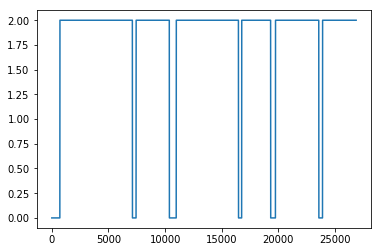

In [45]:
plt.plot(y)

### Shuffle

In [46]:
import random

In [47]:
temp = list(zip(X, y))
random.shuffle(temp)
X, y = zip(*temp)

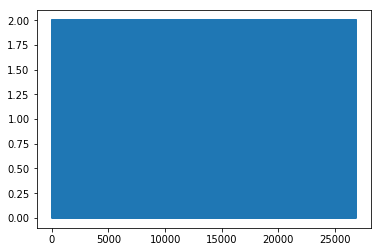

In [48]:
plt.plot(y)

### Pickle

In [49]:
import pickle
import gzip

In [50]:
with gzip.open('../cache/dataset_fixed.pkl.gz', 'wb') as f:
    pickle.dump([X, y], f)

In [51]:
sr

22050